In [1]:
# Import libraries
import os
import re
import pandas as pd
import numpy as np
import seaborn as sms
from datetime import datetime, date, time
from natsort import natsorted
from scipy.io import loadmat  # this is the SciPy module that loads mat-files
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'

In [3]:
# Find usable subjects (i.e., non-outliers)
os.listdir('../../istart-mid/derivatives/')
sub_df=pd.read_csv('../../istart-mid/derivatives/OutlierRuns.tsv',sep='\t')

sub_df=sub_df[sub_df['outlier_run']==False]
sub_df['sub_run']=sub_df['Sub']+'_'+sub_df['run'].astype('str')
sub_df.head()

,Sub,task,run,tsnr,fd_mean,outlier_run,sub_run
0,sub-1001,mid,1,69.988391,0.149729,False,sub-1001_1
1,sub-1001,mid,2,55.697644,0.184703,False,sub-1001_2
2,sub-1002,mid,1,77.148079,0.111157,False,sub-1002_1
3,sub-1002,mid,2,90.519196,0.092381,False,sub-1002_2
4,sub-1003,mid,1,66.602654,0.171448,False,sub-1003_1


In [5]:
#Make a list of the files
Mat_Beh_dir='../../istart/Monetary_Incentive/data'
ML_EvFiles_list=natsorted([os.path.join(root,f) for root,dirs,files in os.walk(
    Mat_Beh_dir) for f in files if 'run' in f])
print("The number of Subjects are: %s"%(len([x for x in os.listdir(Mat_Beh_dir) if x.startswith('sub')])))
print("The number of files are: %s"%(len(ML_EvFiles_list)))
print("----------------------------------------")

# Make Conditions for Run1 and Run2
run_cond=loadmat('%s/../timing/run1.mat'%(Mat_Beh_dir))
run1=run_cond['run']['cond'][0,0]
run1 = np.where(run1==['1'], 'Large_gain', run1)
run1 = np.where(run1==[1], 'Large_gain', run1)
run1 = np.where(run1==['2'], 'Large_loss', run1)
run1 = np.where(run1==['3'], 'Small_gain', run1)
run1 = np.where(run1==['4'], 'Small_loss', run1)
run1 = np.where(run1==['5'], 'Neutral', run1)
run1=np.concatenate(run1)

run_cond=loadmat('%s/../timing/run2.mat'%(Mat_Beh_dir))
run2=run_cond['run']['cond'][0,0]
run2 = np.where(run2==[1], 'Large_gain', run2)
run2 = np.where(run2==['1'], 'Large_gain', run2)
run2 = np.where(run2==['2'], 'Large_loss', run2)
run2 = np.where(run2==['3'], 'Small_gain', run2)
run2 = np.where(run2==['4'], 'Small_loss', run2)
run2 = np.where(run2==['5'], 'Neutral', run2)
run2=np.concatenate(run2)

The number of Subjects are: 61
The number of files are: 83
----------------------------------------


In [7]:
# Print files
display(ML_EvFiles_list)

['../../istart/Monetary_Incentive/data/sub-1001/run-1_output.mat',
 '../../istart/Monetary_Incentive/data/sub-1001/run-2_output.mat',
 '../../istart/Monetary_Incentive/data/sub-1002/run-1_output.mat',
 '../../istart/Monetary_Incentive/data/sub-1002/run-2_output.mat',
 '../../istart/Monetary_Incentive/data/sub-1003/run-1_output.mat',
 '../../istart/Monetary_Incentive/data/sub-1004/run-1_output.mat',
 '../../istart/Monetary_Incentive/data/sub-1004/run-2_output.mat',
 '../../istart/Monetary_Incentive/data/sub-1006/run-1_output.mat',
 '../../istart/Monetary_Incentive/data/sub-1007/run-1_output.mat',
 '../../istart/Monetary_Incentive/data/sub-1007/run-2_output.mat',
 '../../istart/Monetary_Incentive/data/sub-1009/run-1_output.mat',
 '../../istart/Monetary_Incentive/data/sub-1009/run-2_output.mat',
 '../../istart/Monetary_Incentive/data/sub-1010/run-1_output.mat',
 '../../istart/Monetary_Incentive/data/sub-1010/run-2_output.mat',
 '../../istart/Monetary_Incentive/data/sub-1011/run-1_output.m

In [9]:
# Define dataframe for RTs
data=[]
for ML_EvFile in ML_EvFiles_list:
    #print(ML_EvFile)
    sub='sub-'+re.search('sub-(.*)/',ML_EvFile).group(1)
    run=re.search('run-(.*)_out',ML_EvFile).group(1)
    #if sub+'_'+run in sub_df['sub_run'].values:
    #print(sub,run)
    mat = loadmat(ML_EvFile)  # load mat-file
    mdata = mat['output']  # variable in mat file
    mdtype = mdata.dtype  # dtypes of structures are "unsized objects"
    # * SciiencPy reads in structures as structureprintd NumPy arrays of dtype object
    # * The size of the array is the size of the structure array, not the number
    #   elements in any particular field. The shape defaults to 2-dimensional.
    # * For convene make a dictionary of the data using the names from dtypes
    # * Since the structure has only one element, but is 2-D, index it at [0, 0]
    ndata = {n: mdata[n][0, 0] for n in mdtype.names}
    # Reconstruct the columns of the data table from just the time series
    # Use the number of intervals to test if a field is a column or metadata
    columns = [n for n in ndata]
    #Check fo frame
    # now make a data frame, setting the time stamps as the index
    lens=[len(x[0]) for x in ndata.values()]
    if lens.count(lens[0]) == len(lens):
        df = pd.DataFrame(np.transpose(np.concatenate([ndata[c] for c in columns])),
                  columns=columns)
        if run=='1':
            if len(df)==50:
                df['trial_type']=run1[0:50]
            elif len(df)==75:
                df['trial_type']=run1
        if run=='2':
            df['trial_type']=run2
        df['sub']=sub
        df['run']=run
        data.append(df)
df=pd.concat(data)

<Axes: xlabel='RT', ylabel='Count'>

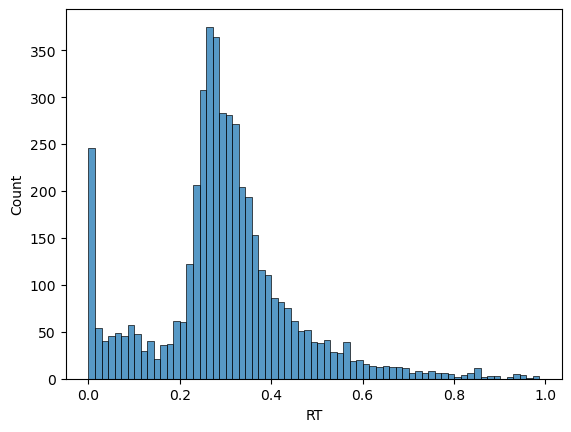

In [11]:
# Plot histogram of RTs
sms.histplot(x=df['RT'])

In [13]:
# Account for missed responses
misses=[]
for sub in df['sub'].unique():
    tmp=df[df['sub']==sub]
    for run in tmp['run'].unique():
        tmp=tmp[tmp['run']==run]
        misses.append(len(tmp[(tmp['RT']==0)&(tmp['outcome']==0)]))
print(" The largest number of missed trials is %s this is less than 20 percent of trials"%(np.max(misses)))

 The largest number of missed trials is 6 this is less than 20 percent of trials


In [15]:
# Sort bi trial type
df.loc[df["trial_type"] == "1", "trial_type"] = "Large_gain"
df['run']=df['run'].astype(int)
df.groupby(by=['sub','run']).max().reset_index()

,sub,run,outcome,trial_starts,target_starts,RT,thresh,trial_type
0,sub-1001,1,1.0,443.596841,445.607023,0.690546,0.584389,Small_loss
1,sub-1001,2,1.0,450.916843,454.927744,0.846985,0.511823,Small_loss
2,sub-1002,1,1.0,443.595531,445.605782,0.491392,0.464767,Small_loss
3,sub-1002,2,1.0,450.928644,454.939221,0.571258,0.466639,Small_loss
4,sub-1003,1,1.0,443.546470,445.555652,0.738533,0.496835,Small_loss
...,...,...,...,...,...,...,...,...
75,sub-3210,1,1.0,679.768941,682.773112,0.823762,0.458219,Small_loss
76,sub-3212,1,1.0,679.607846,682.610161,0.857764,0.456245,Small_loss
77,sub-3218,1,1.0,679.653301,682.655712,0.557942,0.466697,Small_loss
78,sub-3220,1,1.0,679.645557,682.648115,0.922452,0.596440,Small_loss


In [17]:
# Remove misses
no_miss=df[(df['RT']>0.01)]
no_miss[no_miss['RT']==0]
df=no_miss

<Axes: xlabel='RT', ylabel='Count'>

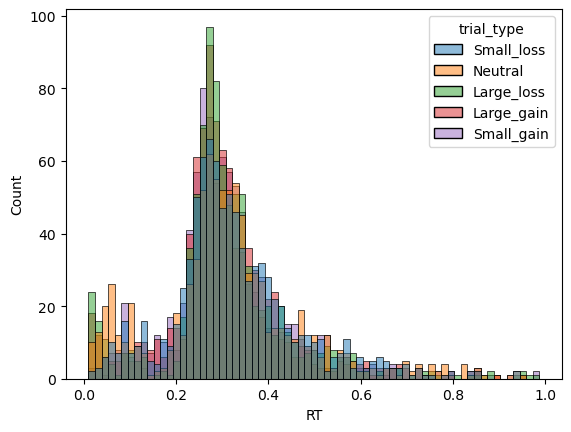

In [19]:
# Plot histogram of RTs by trial type
sms.histplot(x=df['RT'],hue=df['trial_type'])

In [21]:
# Give weights to trial types
df.loc[df["trial_type"] == "1", "trial_type"] = "Large_gain"

df['Trial_code']=df['trial_type'].map({"Large_loss":-2,"Small_loss":-1,"Neutral":0,"Small_gain":1,"Large_gain":2})
df['Trial_code'].unique()

array([-1,  0, -2,  2,  1])

In [23]:
# Check weightings for an individual sub
df[df['sub']=='sub-3199']

,outcome,trial_starts,target_starts,RT,thresh,trial_type,sub,run,Trial_code
0,1.0,4.005512,6.007814,0.317093,0.354215,Small_loss,sub-3199,1,-1
1,1.0,10.013537,12.015883,0.208390,0.359615,Neutral,sub-3199,1,0
2,1.0,20.824335,24.826691,0.347995,0.405430,Large_loss,sub-3199,1,-2
3,0.0,30.432088,33.435449,0.476594,0.469060,Large_loss,sub-3199,1,-2
4,0.0,38.880598,42.884209,0.412769,0.433266,Large_gain,sub-3199,1,2
...,...,...,...,...,...,...,...,...,...
70,0.0,639.997196,643.999625,0.329608,0.338173,Small_gain,sub-3199,1,1
71,0.0,656.809263,658.811312,0.436908,0.383256,Small_gain,sub-3199,1,1
72,1.0,664.016155,667.018345,0.042789,0.324323,Small_loss,sub-3199,1,-1
73,1.0,670.022225,674.024309,0.380891,0.478732,Small_gain,sub-3199,1,1


,sub,trial_type,outcome,trial_starts,target_starts,RT,thresh,run,Trial_code
0,sub-1001,Large_gain,1.0,246.980226,249.991329,0.305435,0.418198,1.5,2.0
1,sub-1001,Large_loss,1.0,185.605540,188.116553,0.308371,0.411154,1.5,-2.0
2,sub-1001,Neutral,1.0,207.873973,209.884223,0.332187,0.443540,1.5,0.0
3,sub-1001,Small_gain,1.0,281.873566,285.883902,0.320507,0.376292,1.5,1.0
4,sub-1001,Small_loss,1.0,154.275646,158.286305,0.367956,0.413490,1.0,-1.0


/var/folders/m6/p7f91dqd37d_mdjnjbx6xdy80000gn/T/ipykernel_26485/2923311723.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sms.barplot(


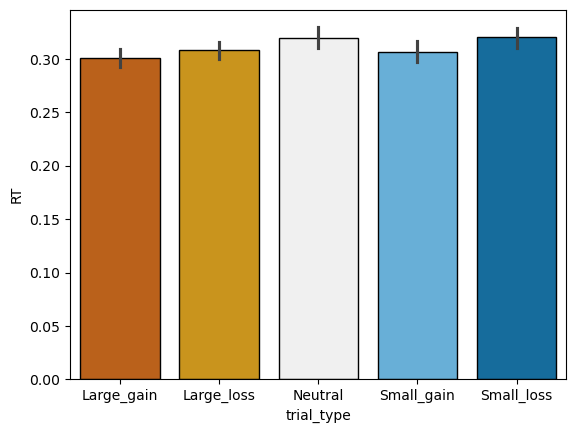

In [25]:
# Plot avg. RT across all subs; would be nice to run this for individual subs
#df['run']=df['run'].astype(int)
#group_df=df.groupby(by=['sub','trial_type']).median()
#group_df=group_df.reset_index()
#display(group_df.head())
#display(group_df)
#g=sms.barplot(x='Trial_code',y='RT',data=group_df,errorbar=('ci',68),palette='RdBu')
#plt.savefig('figures/RT_BAR.svg')
#plt.show()

df['run'] = df['run'].astype(int)
group_df = df.groupby(by=['sub', 'trial_type']).median()
group_df = group_df.reset_index()
display(group_df.head())

# Define custom gradient palette
gradient_palette = ["#D55E00", "#E69F00", "#F0F0F0", "#56B4E9", "#0072B2"]  # Deep orange to deep teal

# Create barplot
g = sms.barplot(
    x='trial_type', 
    y='RT', 
    data=group_df, 
    errorbar=('ci', 68), 
    palette=gradient_palette
)

# Add outlines to each bar
for bar in g.patches:
    bar.set_edgecolor("black")  # Black outline
    bar.set_linewidth(1)        # Outline thickness

# Save and display the plot
# plt.savefig('figures/RT_BAR.svg')
plt.show()

#plt.savefig('~/Desktop/group-RT.svg', format='svg')

/var/folders/m6/p7f91dqd37d_mdjnjbx6xdy80000gn/T/ipykernel_26485/772522360.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sms.barplot(x='Trial_code', y='RT', data=group_df, errorbar=('ci', 68), palette=gradient_palette)


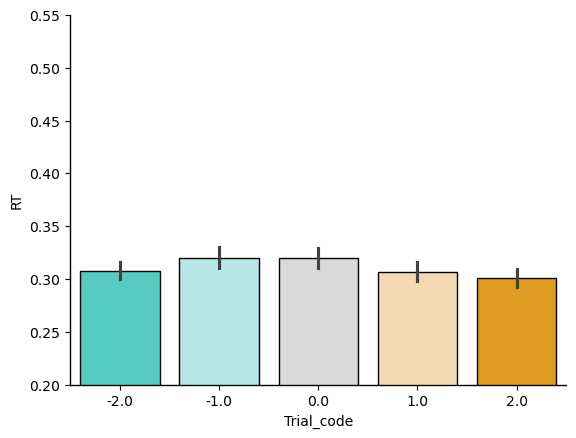

In [27]:
import matplotlib.pyplot as plt
import seaborn as sms
from scipy import stats
from scipy.stats import ttest_rel
import numpy as np

# Plot the barplot with y-axis range restricted
#gradient_palette = ["#FF7F0E", "#FFB07C", "#D9D9D9", "#7FCDBB", "#1F78B4"]
#gradient_palette = ["#FFA500", "#FFD8A8", "#D9D9D9", "#A7DBD8", "#008080"]
gradient_palette = ["#40E0D0", "#AFEEEE", "#D9D9D9", "#FFD8A8", "#FFA500"]
g = sms.barplot(x='Trial_code', y='RT', data=group_df, errorbar=('ci', 68), palette=gradient_palette)

# Set the y-axis range
plt.ylim(0.2, 0.55)

# Add staggered significance annotations to the plot
#add_staggered_significance_annotations(bar_positions, heights, p_values)

# Add outlines to each bar
for bar in g.patches:
    bar.set_edgecolor("black")  # Black outline
    bar.set_linewidth(1)        # Outline thickness

# Remove the top and right spines (borders)
g.spines['top'].set_visible(False)
g.spines['right'].set_visible(False)

# Ensure x and y axes retain their black spines
g.spines['left'].set_color("black")
g.spines['bottom'].set_color("black")

# Optional: Adjust the thickness of the remaining spines
g.spines['left'].set_linewidth(1)
g.spines['bottom'].set_linewidth(1)

# Show the plot
plt.savefig('group-RT.svg', format='svg')
plt.show()

/var/folders/m6/p7f91dqd37d_mdjnjbx6xdy80000gn/T/ipykernel_26485/3034688244.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g=sms.barplot(x='Trial_code',y='RT',errorbar=('ci',68),data=sub_df,palette=gradient_palette)


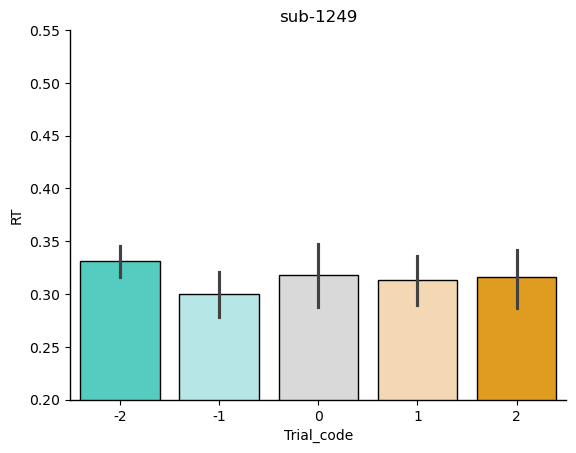

In [29]:
# Plot avg. RT for individual subs
# sub-1016, 1247, 1249 all low VBeta
# sub-3206 great high VBeta
sub_df = df[df['sub']=='sub-1249']

gradient_palette = ["#40E0D0", "#AFEEEE", "#D9D9D9", "#FFD8A8", "#FFA500"]
g=sms.barplot(x='Trial_code',y='RT',errorbar=('ci',68),data=sub_df,palette=gradient_palette)
# Set the y-axis range
plt.ylim(0.2, 0.55)
#g.set_title(str(sub_df['sub']))
sub_df
title=sub_df['sub'].iloc[1]
g.set_title(str(title))
# Add outlines to each bar
for bar in g.patches:
    bar.set_edgecolor("black")  # Black outline
    bar.set_linewidth(1)        # Outline thickness
# Remove the top and right spines (borders)
g.spines['top'].set_visible(False)
g.spines['right'].set_visible(False)

# Ensure x and y axes retain their black spines
g.spines['left'].set_color("black")
g.spines['bottom'].set_color("black")

# Optional: Adjust the thickness of the remaining spines
g.spines['left'].set_linewidth(1)
g.spines['bottom'].set_linewidth(1)
##plt.savefig('figures/RT_BAR.svg')
plt.savefig('sub-1249-RT.svg', format='svg')
plt.show()

In [31]:
# Is mean RT different for LG>N?
from scipy.stats import ttest_rel
print("Is the Mean RT difference between large and Neutral significant?")
ttest_rel(group_df[group_df['trial_type']=='Large_gain']['RT'],
         group_df[group_df['trial_type']=='Neutral']['RT'])

Is the Mean RT difference between large and Neutral significant?


TtestResult(statistic=-2.203953423148404, pvalue=0.03165524096557053, df=56)

In [33]:
# Is mean RT different for LL>SL?
print("Is the Mean RT difference between large and small losses significant")

ttest_rel(group_df[group_df['trial_type']=='Large_loss']['RT'],
         group_df[group_df['trial_type']=='Neutral']['RT'])

Is the Mean RT difference between large and small losses significant


TtestResult(statistic=-1.2357526896496092, pvalue=0.2217093315588961, df=56)

In [35]:
# Determine VBeta (i.e., how well does data fit inverted V for RTs?) for each sub
data=[]
#polynomial fit with degree = 2
for sub in group_df['sub'].unique():
    tmp=group_df[group_df['sub']==sub]
    LG_RT=tmp[tmp['trial_type']=="Large_gain"]['RT'].values[0]
    LL_RT=tmp[tmp['trial_type']=="Large_loss"]['RT'].values[0]
    Neu_RT=tmp[tmp['trial_type']=="Neutral"]['RT'].values[0]
    model = np.poly1d(np.polyfit(tmp['Trial_code'].values, tmp['RT'].values, 2))
    
    data.append([sub,model[2],
                 LG_RT-Neu_RT,
                 LL_RT-Neu_RT,
                 (LG_RT-Neu_RT)-(LL_RT-Neu_RT)
                ])
Fits=pd.DataFrame(columns=['Sub','V_beta','LG-N','LL-N',"rel_rew"],data=data)
Fits.to_csv('../derivatives/Fits_of_RT.csv',index=False)

In [37]:
# Print Fits
Fits.head()

,Sub,V_beta,LG-N,LL-N,rel_rew
0,sub-1001,-0.008945,-0.026752,-0.023816,-0.002937
1,sub-1002,-0.013022,-0.072843,-0.063259,-0.009585
2,sub-1003,0.000093,0.054024,-0.009556,0.063580
3,sub-1004,-0.002456,0.020756,-0.019793,0.040550
4,sub-1006,-0.005296,-0.023401,-0.022996,-0.000405


In [39]:
# Read individual diff measures
per_df=pd.read_excel('MID participant tracker_ 1.xlsx',sheet_name='model 4E basemodel 5')
per_df['Subject']='sub-'+per_df['Subject'].astype('str')
per_df.head()

,Subject,Ones,tsnr_demean,fd_mean_demean,Composite_Reward,Composite_Reward_Squared_demean,comp-SU,com RS xSU demeaned,SU x rs 2,VBeta_demean,Fit*RS_demean,FIT*RS^2_demean
0,sub-1001.0,1.0,-0.427375,0.048571,0.469388,-8.028738,0.491868,-0.329042,-0.630447,-0.003551,-0.003695,0.017792
1,sub-1003.0,1.0,-0.162367,0.124435,0.469388,-8.028738,0.006384,-0.556922,3.267372,0.004369,0.000023,-0.045797
2,sub-1004.0,1.0,-0.124384,-0.456402,2.469388,-2.151187,-0.284906,-1.263462,3.931514,0.002530,0.004219,-0.016160
3,sub-1006.0,1.0,1.312499,-0.852311,-0.530612,-7.967514,-1.158776,0.054942,12.551192,-0.000310,-0.001863,-0.008246
4,sub-1009.0,1.0,1.190812,0.054972,1.469388,-6.089963,-1.158776,-2.262610,10.375531,0.003308,0.002832,-0.030862


In [41]:
# Add VBeta to df with other indiv diff measures
total_df=pd.merge(Fits, per_df, how='left', left_on=['Sub'], right_on=['Subject'])
total_df.head()
# This is printing a bunch of NaNs, I think bc we've tampered with the MID participant tracker _ 1.xlsx file from the previous kernel

,Sub,V_beta,LG-N,LL-N,rel_rew,Subject,Ones,tsnr_demean,fd_mean_demean,Composite_Reward,Composite_Reward_Squared_demean,comp-SU,com RS xSU demeaned,SU x rs 2,VBeta_demean,Fit*RS_demean,FIT*RS^2_demean
0,sub-1001,-0.008945,-0.026752,-0.023816,-0.002937,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,sub-1002,-0.013022,-0.072843,-0.063259,-0.009585,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,sub-1003,0.000093,0.054024,-0.009556,0.063580,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,sub-1004,-0.002456,0.020756,-0.019793,0.040550,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,sub-1006,-0.005296,-0.023401,-0.022996,-0.000405,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


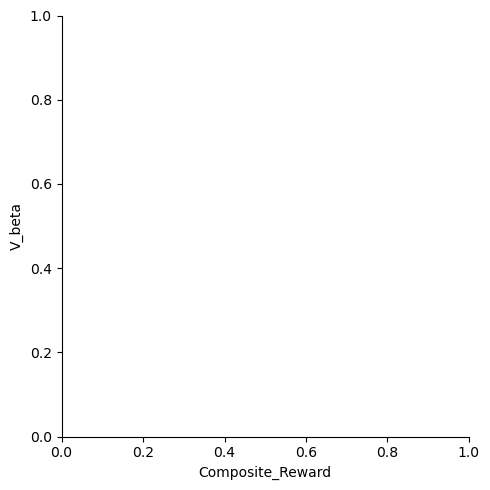

ValueError: x and y must have length at least 2.

In [43]:
# Generate scatterplots: VBeta & other contrasts by Composite Reward (i.e., Reward Sensitivity)
from scipy.stats import pearsonr,kendalltau
responses=['V_beta','LG-N','LL-N']#'rel_rew']

total_df=total_df[~total_df['Composite_Reward'].isna()]

for resp in responses:
    sms.lmplot(x='Composite_Reward',y=resp,data=total_df,order=1)
    plt.show()
    r,p=pearsonr(total_df['Composite_Reward'],total_df[resp])
    print('r:  %s p: %s'%(r,p))
for resp in responses:
    sms.lmplot(x='Composite_Reward',y=resp,data=total_df,order=2)
    plt.show()
    r,p=pearsonr(total_df['Composite_Reward_Squared_demean'],total_df[resp])
    print('r:  %s p: %s'%(r,p))

/var/folders/m6/p7f91dqd37d_mdjnjbx6xdy80000gn/T/ipykernel_26485/221505310.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Condition', y='Z-stat', data=df_melted, palette=gradient_palette, errorbar='se')


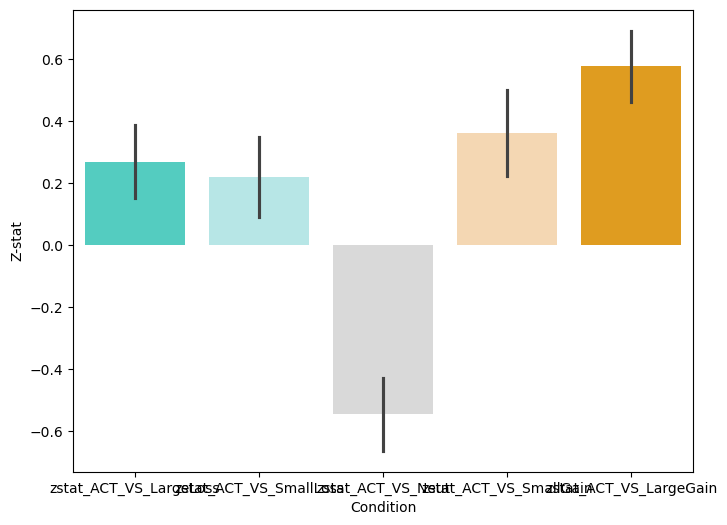

In [45]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the data
file_path = '~/Documents/Github/istart-mid-clean/code/total_df_n46.xlsx'
df = pd.read_excel(file_path)

# Filter relevant columns
columns_of_interest = ['zstat_ACT_VS_LargeLoss', 'zstat_ACT_VS_SmallLoss', 'zstat_ACT_VS_Neut', 
                       'zstat_ACT_VS_SmallGain', 'zstat_ACT_VS_LargeGain']

# Reshape the data for seaborn plotting
df_melted = df[columns_of_interest].melt(var_name='Condition', value_name='Z-stat')

# Plot the barplot with error bars using standard error of the mean (SEM)
gradient_palette = ["#40E0D0", "#AFEEEE", "#D9D9D9", "#FFD8A8", "#FFA500"]
plt.figure(figsize=(8, 6))
sns.barplot(x='Condition', y='Z-stat', data=df_melted, palette=gradient_palette, errorbar='se')

# Show the plot
plt.show()

In [ ]:
# Load the data
file_path = '~/Documents/Github/istart-mid-clean/code/total_df_n46.xlsx'
df = pd.read_excel(file_path)

# Filter relevant columns
columns_of_interest = ['zstat_ACT_VS_LargeLoss', 'zstat_ACT_VS_SmallLoss', 'zstat_ACT_VS_Neut', 
                       'zstat_ACT_VS_SmallGain', 'zstat_ACT_VS_LargeGain']

# Reshape the data for seaborn plotting
df_melted = df[columns_of_interest].melt(var_name='Condition', value_name='Z-stat')

# Plot the barplot with error bars using standard error of the mean (SEM)
gradient_palette = ["#40E0D0", "#AFEEEE", "#D9D9D9", "#FFD8A8", "#FFA500"]
plt.figure(figsize=(8, 6))
ax = sns.barplot(x='Condition', y='Z-stat', data=df_melted, palette=gradient_palette, errorbar='se')

# Add outlines to the bars
for bar in ax.patches:
    bar.set_edgecolor('black')  # Set the edge color to black
    bar.set_linewidth(1.5)  # Adjust the border width if necessary

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Show the plot
plt.show()